# Cancer Dataset Analysis

### AAEs Analysis

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mlp_to_qbaf_converter.mlp_to_qbaf import MLPToQBAF
import Uncertainpy.src.uncertainpy.gradual as grad
from mlp_to_qbaf_converter.argument_attribution_explanation import AAE
from mlp_to_qbaf_converter.relation_attribution_explanation import RAE
from mlp_to_qbaf_converter.utils import plot_qbaf
from tqdm import tqdm
from scipy.stats import kendalltau, spearmanr
import joblib

We have trained MLP Classifers for the Cancer dataset on various hidden layer sizes. We have then translated to QBAFs and computed the AAE gradient score for each of the above models and different levels of sparification. We have then compared the most important argument (neuron) between the sparsifed and original models, evaluating whether the most important neuron is the same in both models.

The sparsification levels are: 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%

In [2]:
max_argument_mlp_dict = {}
gradient_scores_dict = {}
rankings_dict = {}
removal_impacts_dict = {}


for mlp in Path("../../outputs/cancer/aae").glob("*_gradient.npz"):

    file_name = mlp.stem
    # mlp_size1_size2_size3..._gradient.npz
    mlp_size = file_name.replace("_gradient","")
    print(mlp_size)

    data = np.load(mlp, allow_pickle=True)

    max_argument_mlp_dict[mlp_size] = data["max_arguments"]
    gradient_scores_dict[mlp_size] = data["top_scores"]
    rankings_dict[mlp_size] = data["rankings"]
    removal_impacts_dict[mlp_size] = data["impacts"]
    

mlp5_5
mlp50
mlp10_10
mlp25_25
mlp100
mlp10_10_10
mlp80
mlp100_25
mlp40_40
mlp30_30
mlp20
mlp10_50_10
mlp70
mlp60
mlp30_30_30
mlp30
mlp15_15
mlp65_65
mlp50_50
mlp25_100
mlp20_20
mlp90
mlp10_100_10
mlp20_20_20
mlp10
mlp45_45
mlp40
mlp3_4
mlp35_35


mlp45_45
mlp90
mlp80
mlp15_15
mlp30_30
mlp3_4
mlp50
mlp10_50_10
mlp30_30_30
mlp60
mlp30
mlp70
mlp10_10
mlp10
mlp10_100_10
mlp100
mlp40_40
mlp100_25
mlp35_35
mlp20_20_20
mlp10_10_10
mlp25_25
mlp40
mlp50_50
mlp5_5


In [3]:
shrink_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
header_shrink = [("Shrink", f"{percent}%") for percent in shrink_percentages]
results_df = pd.DataFrame(columns=[("", "Hidden Layers"), ("", "Total No. Neurons"), ("", "Depth")] + header_shrink)
results_df.columns = pd.MultiIndex.from_tuples(results_df.columns)
sizes = []
depths = []
totals = []

for i, mlp in enumerate(max_argument_mlp_dict):
    size = tuple(map(int, str(mlp)[3:].split("_")))
    sizes.append(size)
    depth = len(size)
    depths.append(depth)
    total_neurons = sum(size)
    totals.append(total_neurons)


    results_df.loc[i, ("", "Hidden Layers")] = str(size)
    results_df.loc[i, ("", "Total No. Neurons")] = total_neurons
    results_df.loc[i, ("", "Depth")] = depth

    results_df.loc[i, header_shrink] = max_argument_mlp_dict[mlp]

In [4]:
# from IPython.display import HTML
# HTML(results_df.style.set_table_styles(
#     [{'selector': 'th', 'props': [('text-align', 'center')]}]
# ).to_html(index=False))


results_df

Shrink                        \
    Hidden Layers Total No. Neurons Depth        10%        20%        30%   
0          (5, 5)                10     2      100.0      100.0      100.0   
1           (50,)                50     1  14.912281  12.280702  11.403509   
2        (10, 10)                20     2   4.385965   2.631579   1.754386   
3        (25, 25)                50     2  31.578947  11.403509   1.754386   
4          (100,)               100     1  19.298246  11.403509   7.894737   
5    (10, 10, 10)                30     3  88.596491  87.719298  88.596491   
6           (80,)                80     1  19.298246   9.649123    8.77193   
7       (100, 25)               125     2  11.403509        0.0        0.0   
8        (40, 40)                80     2  31.578947   5.263158   1.754386   
9        (30, 30)                60     2  22.807018  20.175439  26.315789   
10          (20,)                20     1  42.982456  23.684211  16.666667   
11   (10, 50, 10)                70     3  94.736842  94.736842  93.859649   
12          (70,)                70     1  15.789474    8.77193   9.649123   
13          (60,)                60     1  15.789474    8.77193   7.894737   
14   (30, 30, 30)                90     3  56.140351  34.210526  16.666667   
15          (30,)                30     1  51.754386   32.45614  25.438596   
16       (15, 15)                30     2  78.070175  54.385965   3.508772   
17       (65, 65)               130     2  25.438596  31.578947  38.596491   
18       (50, 50)               100     2  18.421053   0.877193        0.0   
19      (25, 100)               125     2  21.929825  15.789474   17.54386   
20       (20, 20)                40     2  71.929825  74.561404  78.947368   
21          (90,)                90     1   7.017544   7.894737   7.894737   
22  (10, 100, 10)               120     3  92.105263  90.350877  87.719298   
23   (20, 20, 20)                60     3  73.684211  69.298246  47.368421   
24          (10,)                10     1  70.175439  54.385965  46.491228   
25       (45, 45)                90     2  36.842105  24.561404  18.421053   
26          (40,)                40     1  14.912281   5.263158   4.385965   
27         (3, 4)                 7     2      100.0      100.0      100.0   
28       (35, 35)                70     2  10.526316   7.894737   7.017544   

                                                                      
          40%        50%        60%        70%        80%        90%  
0       100.0      100.0      100.0      100.0      100.0      100.0  
1     8.77193  10.526316    8.77193    8.77193  10.526316   7.894737  
2         0.0        0.0   0.877193  80.701754   91.22807      100.0  
3    0.877193   0.877193   0.877193        0.0        0.0        0.0  
4    4.385965   4.385965   4.385965   6.140351   6.140351  16.666667  
5   81.578947  85.087719  81.578947  78.947368  78.947368        0.0  
6   11.403509   7.894737   1.754386   6.140351  10.526316  14.035088  
7         0.0        0.0        0.0   6.140351  33.333333  12.280702  
8         0.0        0.0        0.0        0.0        0.0  49.122807  
9   22.807018   17.54386  15.789474  20.175439  56.140351       50.0  
10  13.157895   9.649123   7.017544    8.77193  18.421053  61.403509  
11  93.859649  93.859649   91.22807  74.561404  69.298246        0.0  
12  13.157895  15.789474  16.666667  18.421053  25.438596  43.859649  
13   7.894737    8.77193    8.77193    8.77193   9.649123   17.54386  
14  10.526316    8.77193   7.894737   4.385965   3.508772   0.877193  
15  25.438596  28.070175   32.45614  29.824561  34.210526  50.877193  
16   3.508772  29.824561  43.859649   4.385965        0.0      100.0  
17  49.122807  52.631579  42.105263   9.649123  31.578947  78.947368  
18        0.0        0.0        0.0        0.0        0.0        0.0  
19  13.157895    8.77193   3.508772   7.894737  10.526316  23.684211  
20  88.596491   67.54386  31.578947  74.561404   41.22807  44.736

In [5]:
max_arg_results = []

for shrink_percentage in header_shrink:
    avg = results_df[shrink_percentage].mean()
    max_arg_results.append(avg)
    print(f"Average for {shrink_percentage[1]} Sparsification: {avg.mean()}")

print(f"Latex row: {"&".join([str(round(x, 1)) for x in max_arg_results])} \\\\")


Average for 10% Sparsification: 42.83121597096189
Average for 20% Sparsification: 34.48275862068966
Average for 30% Sparsification: 30.217785843920144
Average for 40% Sparsification: 28.49364791288566
Average for 50% Sparsification: 30.03629764065336
Average for 60% Sparsification: 29.88505747126437
Average for 70% Sparsification: 31.33696309739867
Average for 80% Sparsification: 35.60193587416818
Average for 90% Sparsification: 39.7156684815487
Latex row: 42.8&34.5&30.2&28.5&30.0&29.9&31.3&35.6&39.7 \\


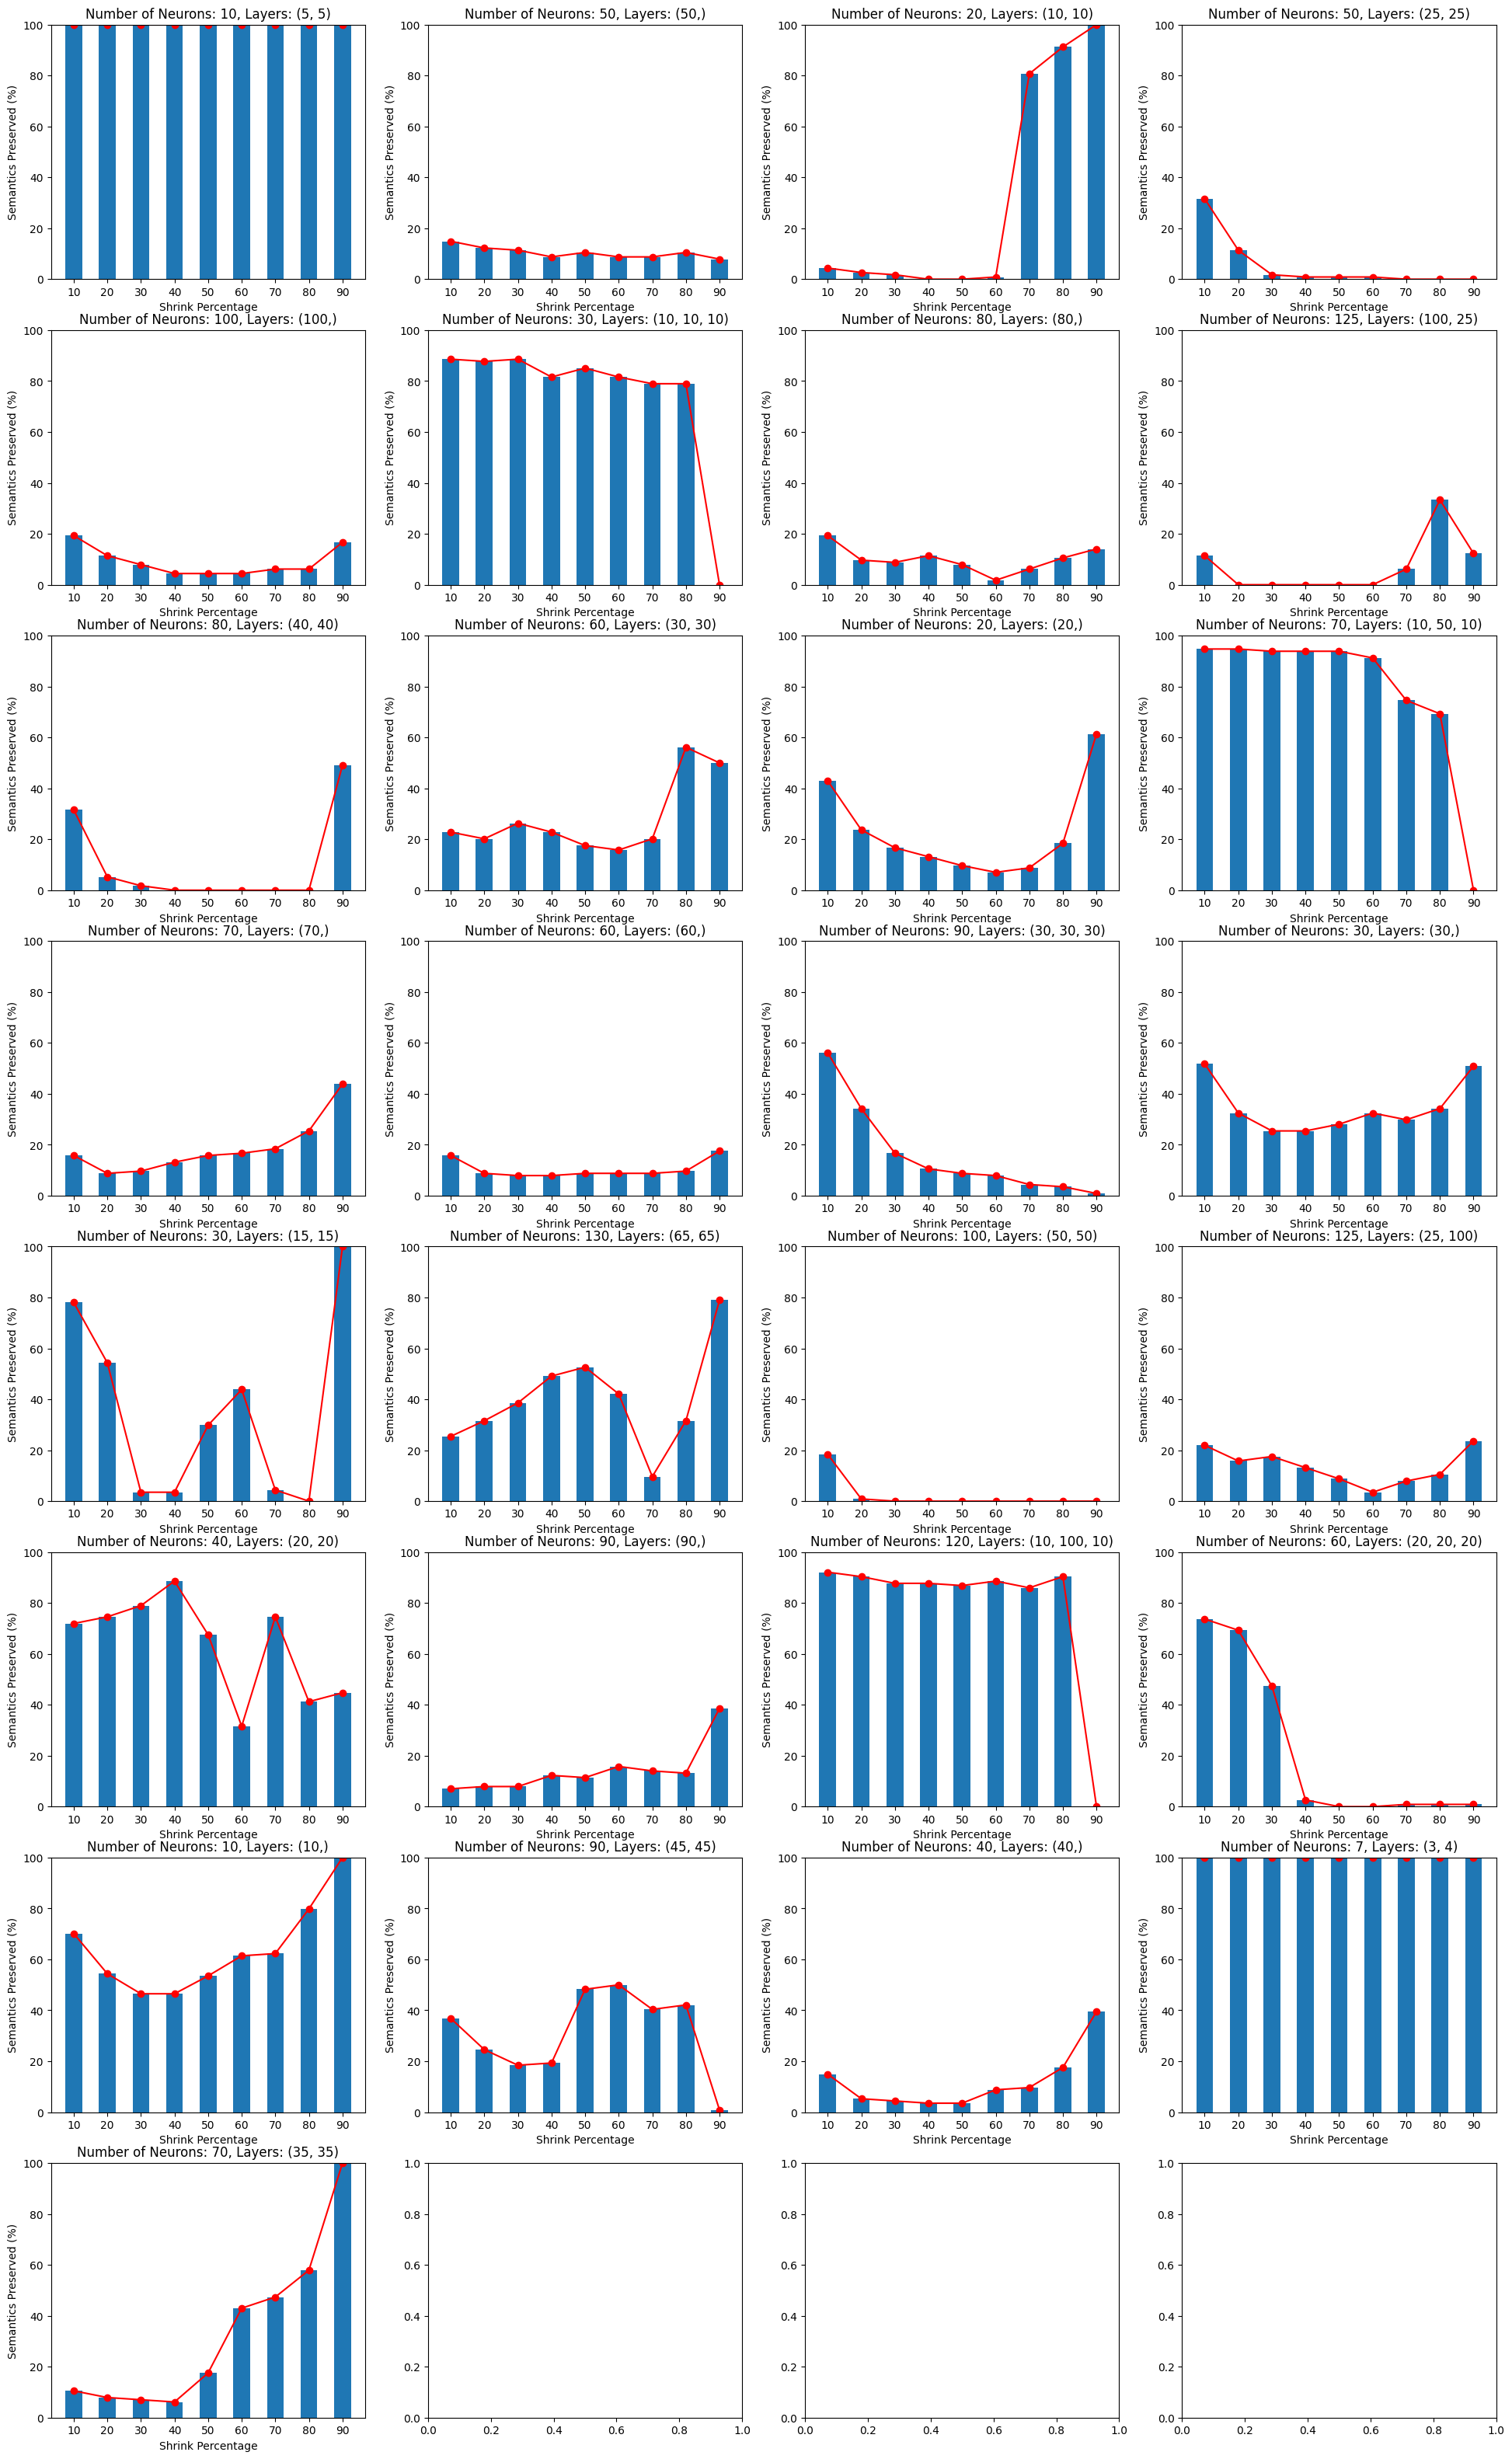

In [6]:
import math

num_sizes = len(sizes)
cols = min(4, math.ceil(math.sqrt(num_sizes)))
rows = math.ceil(num_sizes / cols)
fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

for i, size in enumerate(sizes):
    ax[i//cols, i%cols].bar(shrink_percentages, results_df.iloc[i, 3:], width=5)
    ax[i//cols, i%cols].plot(shrink_percentages, results_df.iloc[i, 3:], marker="o", color="red")
    ax[i//cols, i%cols].set_title(f"Number of Neurons: {totals[i]}, Layers: {size}")
    ax[i//cols, i%cols].set_xlabel("Shrink Percentage")
    ax[i//cols, i%cols].set_ylabel("Semantics Preserved (%)")
    ax[i//cols, i%cols].set_ylim(0, 100)
    ax[i//cols, i%cols].set_xticks(shrink_percentages)


In [7]:
# depths_unique = np.unique(depths)
# depths_unique_sorted_idx = np.argsort(depths_unique)
# depths_unique = depths_unique[depths_unique_sorted_idx]
# average_preserved_depth = np.zeros((len(depths_unique), len(shrink_percentages)))

# for i, depth in enumerate(depths_unique):
#     average_preserved_depth[i] = np.mean(results_df[results_df[("", "Depth")] == depth].iloc[:, 3:], axis=0)

# rows = math.ceil(math.sqrt(len(depths_unique)))
# cols = math.ceil(len(depths_unique) / rows)
# fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

# for i, depth in enumerate(depths_unique):
#     ax[i//cols, i%cols].bar(shrink_percentages, average_preserved_depth[i], width=5)
#     ax[i//cols, i%cols].plot(shrink_percentages, average_preserved_depth[i], marker="o", color="red")
#     ax[i//cols, i%cols].set_title(f"Depth (Number Hidden Layers): {depth}")
#     ax[i//cols, i%cols].set_xlabel("Shrink Percentage")
#     ax[i//cols, i%cols].set_ylabel("Semantics Preserved Average (%)")
#     ax[i//cols, i%cols].set_ylim(0, 100)
#     ax[i//cols, i%cols].set_xticks(shrink_percentages)

# plt.show()

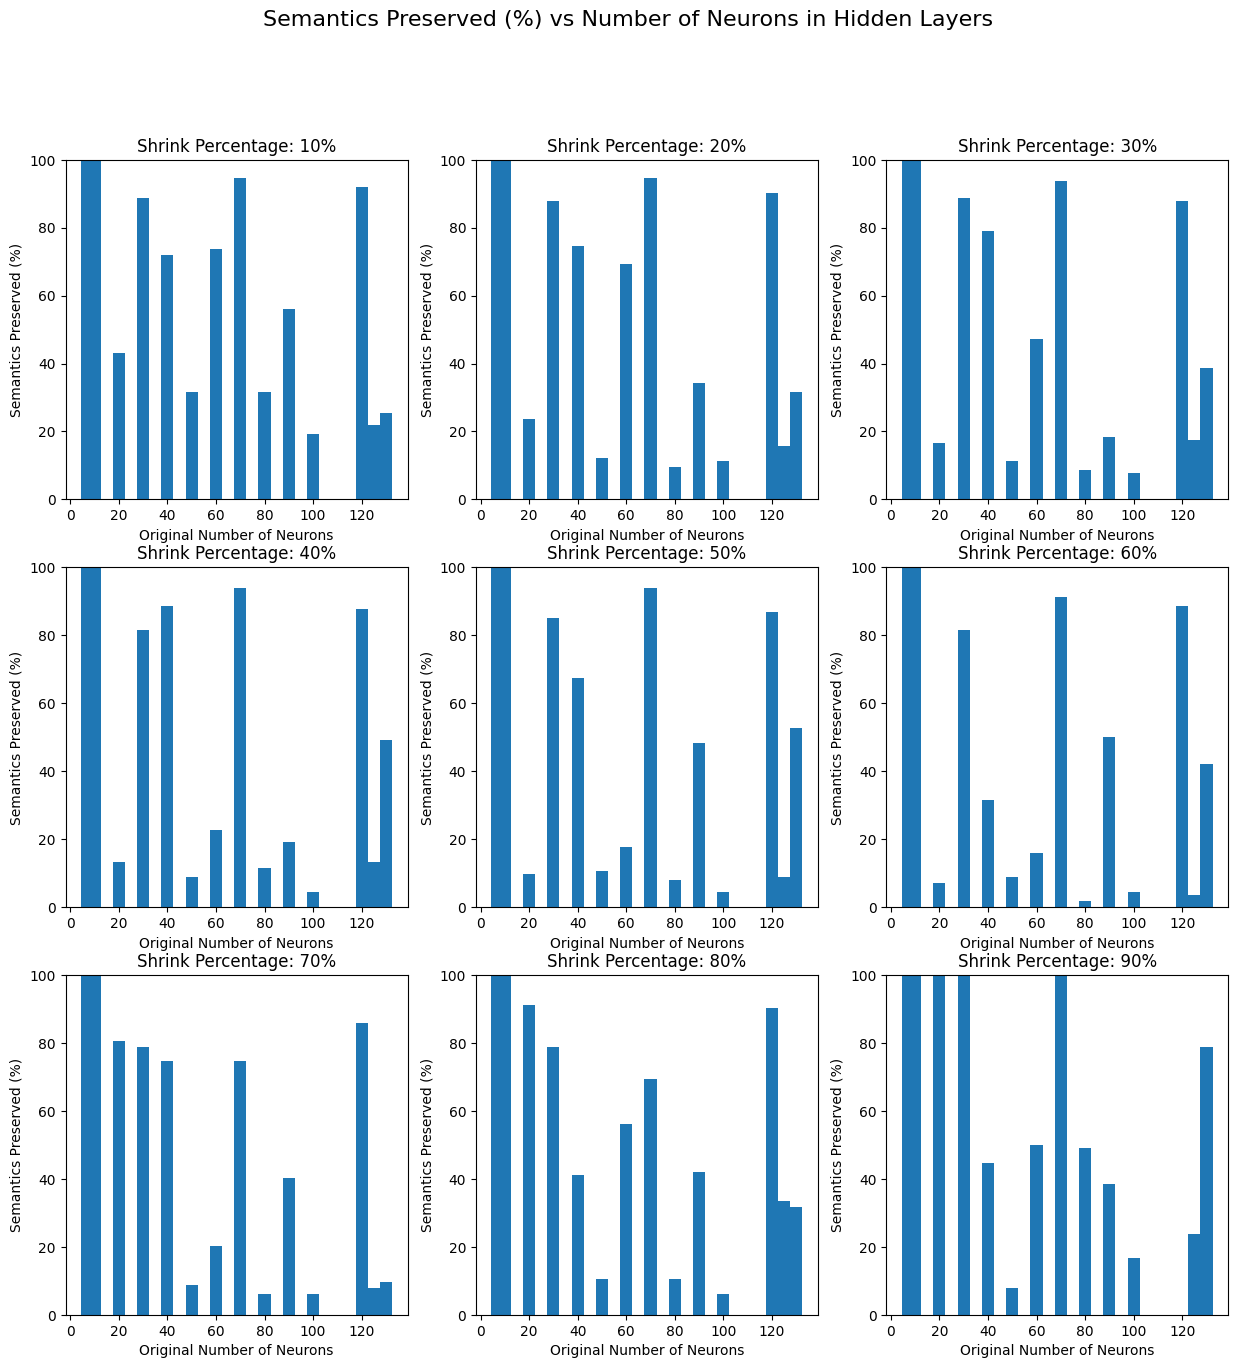

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

totals_sorted_idx = np.argsort(totals)
totals_sorted = np.array(totals)[totals_sorted_idx]

for i, shrink_percentage in enumerate(shrink_percentages):

    percents = results_df.iloc[:, i+3].to_numpy()[totals_sorted_idx]
    
    ax[i//3, i%3].bar(totals_sorted, percents, width=5)
    # ax[i//3, i%3].plot(totals_sorted, percents, marker="o", color="red", linewidth=0.5, markersize=2)
    ax[i//3, i%3].set_title(f"Shrink Percentage: {shrink_percentage}%")
    ax[i//3, i%3].set_xlabel("Original Number of Neurons")
    ax[i//3, i%3].set_ylabel("Semantics Preserved (%)")
    ax[i//3, i%3].set_ylim(0, 100)

# fig.tight_layout()
fig.suptitle("Semantics Preserved (%) vs Number of Neurons in Hidden Layers", fontsize=16)
plt.show()


Further ideas:
<!-- - Track back the most important argument in the sparsifed network to see how much each of the input features contributed to this () -->
- Repeat using other types of AAE (e.g. removal scores)
- Repeat on other datasets, see if we get similar results (maybe later)
- Repeat this style of analysis on RAEs (time complexity issues for SHAP scores if MLPs are large)
- Start researching LRP to find some metrics to check faithfulness of explanations
    - Removal of neurons -> removing the most important neuron should have the biggest impact on the output
    - Perturbation of neurons -> perturbing the most important neuron should have the biggest impact on the output
    - Compare the faithfulness of the explanations before and after sparsification



- Coefficient $\checkmark$
- Ranking (weighting) -> score for cluster and original average
- AAEs
- Other AAE types

In [9]:
kendalltau_coeffs_dict = {}
spearman_coeffs_dict = {}

for mlp in gradient_scores_dict:
    kendalltau_coeffs = np.zeros(((gradient_scores_dict[mlp].shape[0], gradient_scores_dict[mlp].shape[1] - 1)), dtype=float)
    spearman_coeffs = np.zeros(((gradient_scores_dict[mlp].shape[0], gradient_scores_dict[mlp].shape[1] - 1)), dtype=float)
    top_scores = gradient_scores_dict[mlp]
    for example in range(top_scores.shape[0]):
        for sparse_percent in range(1, top_scores.shape[1]):
            kendalltau_coeffs[example, sparse_percent - 1] = kendalltau(np.abs(top_scores[example, 0]), np.abs(top_scores[example, sparse_percent]))[0]
            spearman_coeffs[example, sparse_percent - 1] = spearmanr(np.abs(top_scores[example, 0]), np.abs(top_scores[example, sparse_percent]))[0]

            # Deal with the case where the top scores are the same
            # If the top scores are all the same, then the correlation is 1
            # Otherwise, it is 0
            if np.isnan(kendalltau_coeffs[example, sparse_percent - 1]):
                if np.all(top_scores[example, 0] == top_scores[example, sparse_percent]):
                    kendalltau_coeffs[example, sparse_percent - 1] = 1.0
                else:
                    kendalltau_coeffs[example, sparse_percent - 1] = 0.0
            
            if np.isnan(spearman_coeffs[example, sparse_percent - 1]):
                if np.all(top_scores[example, 0] == top_scores[example, sparse_percent]):
                    spearman_coeffs[example, sparse_percent - 1] = 1.0
                else:
                    spearman_coeffs[example, sparse_percent - 1] = 0.0

    kendalltau_coeffs_dict[mlp] = kendalltau_coeffs
    spearman_coeffs_dict[mlp] = spearman_coeffs
    

/tmp/ipykernel_2706860/912873563.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_coeffs[example, sparse_percent - 1] = spearmanr(np.abs(top_scores[example, 0]), np.abs(top_scores[example, sparse_percent]))[0]


In [10]:

headers = ["MLP Shape", "Number of Neurons"] + [f"{percent}%" for percent in shrink_percentages]
kendalltaucoefficients_df = pd.DataFrame(columns=headers)

for mlp in kendalltau_coeffs_dict:
    hidden_layers = tuple(map(int, (mlp[3:].split("_"))))
    row = [hidden_layers, sum(hidden_layers)]
    row.extend(list(np.mean(kendalltau_coeffs_dict[mlp], axis=0)))
    kendalltaucoefficients_df.loc[len(kendalltaucoefficients_df)] = row

kendalltaucoefficients_df.sort_values("Number of Neurons", inplace=True)

In [11]:
kendalltaucoefficients_df.aggregate({h: ["mean", "max", "min"] for h in headers[2:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.974107,0.973721,0.971655,0.971140,0.970394,0.968676,0.964680,0.964868,0.942942
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,0.855076,0.849393,0.835203,0.798716,0.826858,0.804025,0.786924,0.805662,0.760205


In [12]:
headers = ["MLP Shape", "Number of Neurons"] + [f"{percent}%" for percent in shrink_percentages]
spearman_coefficients_df = pd.DataFrame(columns=headers)

for mlp in spearman_coeffs_dict:
    hidden_layers = tuple(map(int, (mlp[3:].split("_"))))
    row = [hidden_layers, sum(hidden_layers)]
    row.extend(list(np.mean(spearman_coeffs_dict[mlp], axis=0)))
    spearman_coefficients_df.loc[len(spearman_coefficients_df)] = row

spearman_coefficients_df.sort_values("Number of Neurons", inplace=True)

In [13]:
spearman_coefficients_df.aggregate({h: ["mean", "max", "min"] for h in headers[2:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.979027,0.978692,0.976436,0.975799,0.975123,0.973518,0.969880,0.970247,0.958249
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,0.858571,0.853775,0.845698,0.802924,0.832828,0.808515,0.789904,0.813427,0.799420


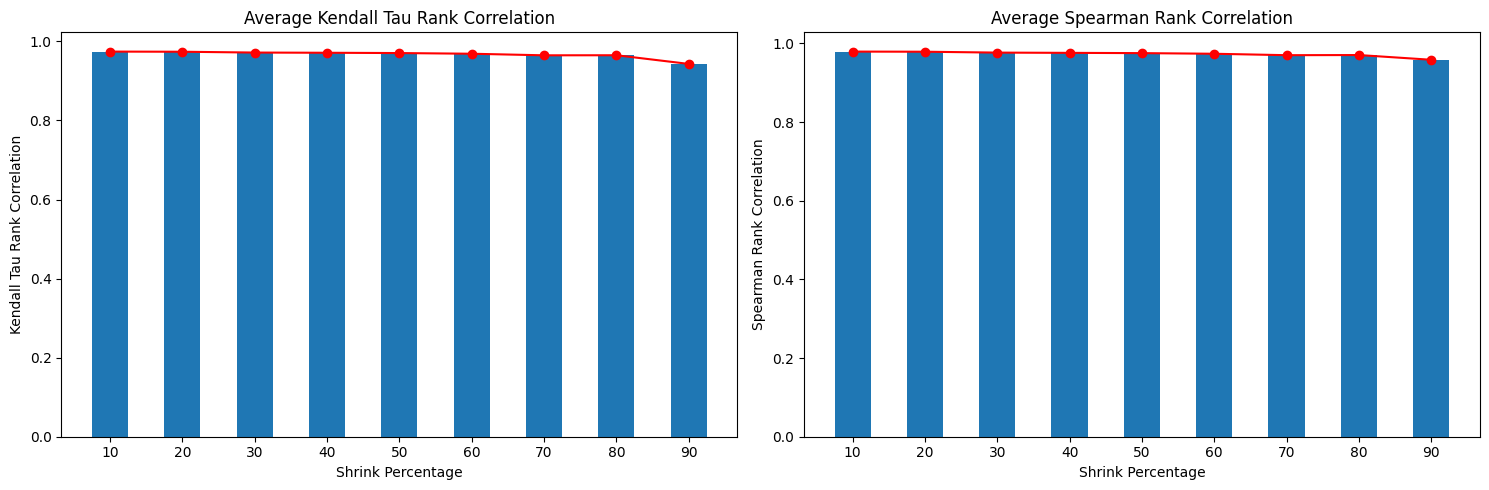

In [14]:
average_kendalltau_ranks = np.zeros((len(shrink_percentages)))

for mlp in kendalltau_coeffs_dict:
    average_kendalltau_ranks += np.mean(kendalltau_coeffs_dict[mlp], axis=0)

average_kendalltau_ranks /= len(kendalltau_coeffs_dict)

average_spearman_ranks = np.zeros((len(shrink_percentages)))

for mlp in spearman_coeffs_dict:
    average_spearman_ranks += np.mean(spearman_coeffs_dict[mlp], axis=0)

average_spearman_ranks /= len(spearman_coeffs_dict)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].bar(shrink_percentages, average_kendalltau_ranks, width=5)
ax[0].plot(shrink_percentages, average_kendalltau_ranks, marker="o", color="red")
ax[0].set_title("Average Kendall Tau Rank Correlation")
ax[0].set_xlabel("Shrink Percentage")
ax[0].set_ylabel("Kendall Tau Rank Correlation")
# ax[0].set_ylim(0, 1)
ax[0].set_xticks(shrink_percentages)
# ax[0].axhline(0, color="black")

ax[1].bar(shrink_percentages, average_spearman_ranks, width=5)
ax[1].plot(shrink_percentages, average_spearman_ranks, marker="o", color="red")
ax[1].set_title("Average Spearman Rank Correlation")
ax[1].set_xlabel("Shrink Percentage")
ax[1].set_ylabel("Spearman Rank Correlation")
# ax[1].set_ylim(0, 1)
ax[1].set_xticks(shrink_percentages)
plt.tight_layout()
plt.show()

In [15]:
shrink_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
top_n_same = np.zeros((len(rankings_dict), len(shrink_percentages)))
top_in_top_n = np.zeros((len(rankings_dict), len(shrink_percentages)))
pearson_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
kendalltau_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
rankings_diff = np.zeros((len(rankings_dict), len(shrink_percentages)))
for m, mlp in enumerate(rankings_dict):
    top_n_same_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages))) 
    top_in_top_n_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    pearson_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    kendalltau_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    rankings_diff_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    for example in range(len(rankings_dict[mlp])):
        for sparse_percent in range(len(rankings_dict[mlp][example])):
            original_scores = rankings_dict[mlp][example][sparse_percent, 0]
            original_scores[:, 1] = np.abs(np.astype(original_scores[:, 1], float))
            sparse_scores = rankings_dict[mlp][example][sparse_percent, 1]
            sparse_scores[:, 1] = np.abs(np.astype(sparse_scores[:, 1], float))
            count_same_rankings = 0
            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: float(x[1]), reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: float(x[1]), reverse=True))
            top_n = min(10, len(sparse_scores_sorted) // 2)
            for i in range(top_n):
                if original_scores_sorted[i, 0] in sparse_scores_sorted[:top_n, 0]:
                    count_same_rankings += 1
            top_n_same_tmp[example, sparse_percent] = count_same_rankings / top_n * 100

            if original_scores_sorted[0, 0] in sparse_scores_sorted[:top_n, 0]:
                top_in_top_n_tmp[example, sparse_percent] = 1
            
            for i in range(len(original_scores_sorted)):
                clustered_i = np.argwhere(sparse_scores_sorted[:, 0] == original_scores_sorted[i, 0])
                if len(clustered_i) == 0:
                    raise ValueError("Could not find the argument in the sparse scores")
                clustered_i = clustered_i[0][0]
                rankings_diff_tmp[example, sparse_percent] += abs(i - clustered_i) / len(original_scores_sorted) * 100
            
            rankings_diff_tmp[example, sparse_percent] /= len(original_scores_sorted)

            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: x[1], reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: x[1], reverse=True))

            pearson_coeffs_tmp[example, sparse_percent] = spearmanr([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
            kendalltau_coeffs_tmp[example, sparse_percent] = kendalltau([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
    top_in_top_n[m] = np.mean(top_in_top_n_tmp, axis=0) * 100
    pearson_coeffs[m] = np.mean(pearson_coeffs_tmp, axis=0)
    top_n_same[m] = np.mean(top_n_same_tmp, axis=0)
    kendalltau_coeffs[m] = np.mean(kendalltau_coeffs_tmp, axis=0)
    rankings_diff[m] = np.mean(rankings_diff_tmp, axis=0)


/tmp/ipykernel_2706860/11805857.py:43: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_coeffs_tmp[example, sparse_percent] = spearmanr([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]


In [16]:
headers = ["MLP Shape", "Number of Neurons", "Number of Hidden Layers"] + [f"{percent}%" for percent in shrink_percentages]
top_n_same_df = pd.DataFrame(columns=headers)
top_n_same_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["Number of Hidden Layers"] = [len(x) for x in top_n_same_df["MLP Shape"]]
top_n_same_df[headers[3:]] = top_n_same
top_n_same_df.sort_values("Number of Neurons", inplace=True)

In [17]:
top_n_same_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,85.583787,77.819117,71.382335,67.934059,67.640653,67.268603,65.620085,60.362976,47.192982
max,94.298246,92.017544,91.052632,90.526316,95.701754,93.070175,94.912281,86.929825,92.543860
min,74.210526,55.175439,41.666667,35.263158,36.140351,43.508772,32.192982,16.578947,10.789474


In [18]:
rankings_diff_df = pd.DataFrame(columns=headers)
rankings_diff_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["Number of Hidden Layers"] = [len(x) for x in rankings_diff_df["MLP Shape"]]
rankings_diff_df[headers[3:]] = rankings_diff
rankings_diff_df.sort_values("Number of Neurons", inplace=True)


In [19]:
rankings_diff_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,6.649172,8.910517,11.177010,13.059377,14.837773,16.841318,19.746134,22.758030,27.030983
max,20.327963,20.232009,20.325684,25.843765,25.843765,28.402549,29.430510,35.418020,37.723784
min,4.100634,6.573653,8.575588,10.162867,11.447037,12.570724,14.256291,16.568943,21.025779


In [20]:
top_in_top_n_df = pd.DataFrame(columns=headers)
top_in_top_n_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["Number of Hidden Layers"] = [len(x) for x in top_in_top_n_df["MLP Shape"]]
top_in_top_n_df[headers[3:]] = top_in_top_n
top_in_top_n_df.sort_values("Number of Neurons", inplace=True)

In [21]:
top_in_top_n_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,99.274047,99.546279,99.364791,98.396854,95.523291,93.859649,93.254688,94.101633,88.656987
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
min,91.228070,96.491228,95.614035,79.824561,53.508772,50.000000,50.000000,68.421053,0.000000


In [22]:
pearson_coeffs_df = pd.DataFrame(columns=headers)
pearson_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["Number of Hidden Layers"] = [len(x) for x in pearson_coeffs_df["MLP Shape"]]
pearson_coeffs_df[headers[3:]] = pearson_coeffs
pearson_coeffs_df.sort_values("Number of Neurons", inplace=True)

In [23]:
pearson_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.965306,0.962891,0.957510,0.951893,0.941552,0.920677,0.900555,0.874125,0.823752
max,0.999448,0.998111,0.997973,0.997839,0.997583,0.997248,0.996933,0.997574,0.994296
min,0.814154,0.816484,0.853807,0.825135,0.811161,0.603522,0.603522,0.530168,0.142694


In [24]:
kendalltau_coeffs_df = pd.DataFrame(columns=headers)
kendalltau_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["Number of Hidden Layers"] = [len(x) for x in kendalltau_coeffs_df["MLP Shape"]]
kendalltau_coeffs_df[headers[3:]] = kendalltau_coeffs
kendalltau_coeffs_df.sort_values("Number of Neurons", inplace=True)


In [25]:
kendalltau_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.967445,0.965102,0.960256,0.955038,0.945054,0.918210,0.891446,0.858251,0.782689
max,0.997161,0.995875,0.995471,0.994927,0.992465,0.990468,0.991085,0.987408,0.982507
min,0.828920,0.830695,0.859345,0.838062,0.835202,0.478895,0.478895,0.478895,0.121759


#### Creating a faithfulness score

In SpArX, evalaute faithfulness using a structural faithfulness score and input-output faithfuless. 

Do something similar by looking at the impact of removal of the most important argument on the strength of the topic argument. If the strength after removal is roughly the same in both then this shows the sparsification is faithful (similar to input/output faithfulness).

Structural faithfulness: Create a score based on how close the averaged rankings are to the sparse rankings -> large difference = lower structural faithfulness.

Next steps: Compare to ML methods -> just compute AAEs on input arguments

### RAEs Analysis

![RAE Illustration](RAE_Illustration.png)


In [26]:
rankings_dict = {}
rankings_variances_dict = {}
rankings_weighted_dict = {}
non_averaged_rankings_percents = {}
non_averaged_kendalltau_coeffs_dict = {}
non_averaged_pearson_coeffs_dict = {}

for mlp in Path("../../outputs/cancer/rae").glob("*_shap.npz"):

    file_name = mlp.stem
    # mlp_size1_size2_size3..._gradient.npz
    mlp_size = file_name.replace("_shap","")
    print(mlp_size)

    data = np.load(mlp, allow_pickle=True)

    rankings_dict[mlp_size] = data["rankings"]

    try:
        non_averaged_rankings_percents[mlp_size] = data["non_averaged_rankings"]
        rankings_weighted_dict[mlp_size] = data["rankings_weighted"]
        rankings_variances_dict[mlp_size] = data["rankings_variances"]
        non_averaged_kendalltau_coeffs_dict[mlp_size] = data["kendall_taus"]
        non_averaged_pearson_coeffs_dict[mlp_size] = data["pearson_correlations"]
    except Exception:
        # Haven't been calculated yet
        continue

mlp3_3
mlp3
mlp2_10
mlp2
mlp2_2_2
mlp2_2


In [27]:
def remove_relation_type(arr):
    for i in range(len(arr)):
        if "Attack" in arr[i]:
            arr[i] = arr[i].replace("Attack(", "").replace(")", "")
        else:
            arr[i] = arr[i].replace("Support(", "").replace(")", "")

    return arr 

shrink_percentages = [20, 40, 60, 80]
top_n_same = np.zeros((len(rankings_dict), len(shrink_percentages)))
top_in_top_n = np.zeros((len(rankings_dict), len(shrink_percentages)))
pearson_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
kendalltau_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
rankings_diff = np.zeros((len(rankings_dict), len(shrink_percentages)))
for m, mlp in enumerate(rankings_dict):
    top_n_same_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages))) 
    top_in_top_n_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    pearson_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    kendalltau_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    rankings_diff_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    for example in range(len(rankings_dict[mlp])):
        for sparse_percent in range(len(rankings_dict[mlp][example])):
            original_scores = rankings_dict[mlp][example][sparse_percent, 0]
            original_scores[:, 1] = np.abs(np.astype(original_scores[:, 1], float))
            sparse_scores = rankings_dict[mlp][example][sparse_percent, 1]
            sparse_scores[:, 1] = np.abs(np.astype(sparse_scores[:, 1], float))
            sparse_scores[:, 0] = remove_relation_type(sparse_scores[:, 0])
            count_same_rankings = 0
            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: float(x[1]), reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: float(x[1]), reverse=True))
            top_n = min(10, len(sparse_scores_sorted) // 2)
            for i in range(top_n):
                if original_scores_sorted[i, 0] in sparse_scores_sorted[:top_n, 0]:
                    count_same_rankings += 1
            top_n_same_tmp[example, sparse_percent] = count_same_rankings / top_n * 100

            if original_scores_sorted[0, 0] in sparse_scores_sorted[:top_n, 0]:
                top_in_top_n_tmp[example, sparse_percent] = 1
            
            for i in range(len(original_scores_sorted)):
                clustered_i = np.argwhere(sparse_scores_sorted[:, 0] == original_scores_sorted[i, 0])
                if len(clustered_i) == 0:
                    raise ValueError("Could not find the argument in the sparse scores")
                clustered_i = clustered_i[0][0]
                rankings_diff_tmp[example, sparse_percent] += abs(i - clustered_i) / len(original_scores_sorted) * 100
            
            rankings_diff_tmp[example, sparse_percent] /= len(original_scores_sorted)

            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: x[1], reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: x[1], reverse=True))

            pearson_coeffs_tmp[example, sparse_percent] = spearmanr([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
            kendalltau_coeffs_tmp[example, sparse_percent] = kendalltau([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
    
    top_in_top_n[m] = np.mean(top_in_top_n_tmp, axis=0) * 100
    pearson_coeffs[m] = np.mean(pearson_coeffs_tmp, axis=0)
    top_n_same[m] = np.mean(top_n_same_tmp, axis=0)
    kendalltau_coeffs[m] = np.mean(kendalltau_coeffs_tmp, axis=0)
    rankings_diff[m] = np.mean(rankings_diff_tmp, axis=0)

Defining Preservation:
- Does the disribution of the RAEs stay the same? KL Divergence/ Wasserstein distance 
- Are the highest ranked relations the same? When the scores of the corresponding relations are averaged, do the top relations stay the same?

In [28]:
headers = ["MLP Shape", "Number of Neurons", "Number of Hidden Layers"] + [f"{percent}%" for percent in shrink_percentages]
top_n_same_df = pd.DataFrame(columns=headers)
top_n_same_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["Number of Hidden Layers"] = [len(x) for x in top_n_same_df["MLP Shape"]]
top_n_same_df[headers[3:]] = top_n_same
top_n_same_df.sort_values("Number of Neurons", inplace=True)

top_n_same_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,26.725146,23.172515,26.710526,28.289474
max,44.122807,44.122807,44.122807,44.561404
min,11.052632,11.052632,11.052632,11.052632


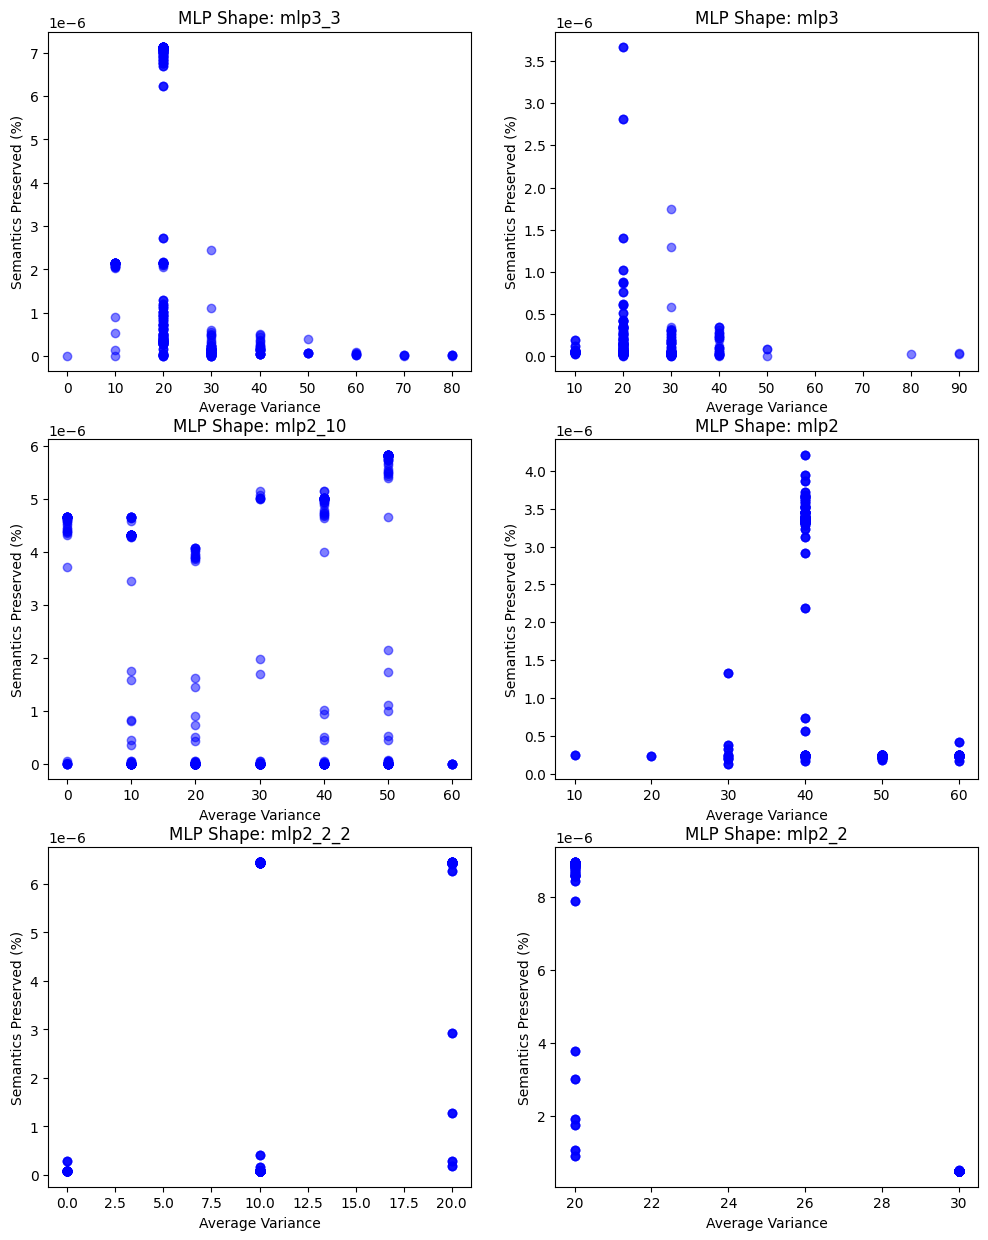

In [29]:
rows = math.ceil(math.sqrt(len(rankings_dict)))
cols = math.ceil(len(rankings_dict) / rows)

fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

mean_variances = np.zeros((len(rankings_variances_dict), len(shrink_percentages)))

for m, mlp in enumerate(rankings_variances_dict):
    var_dict_tmp = np.zeros((len(rankings_variances_dict[mlp]), len(shrink_percentages)))
    avg_variances = []
    avg_preservations = []
    for example in range(len(rankings_variances_dict[mlp])):
        for sparse_percent in range(len(rankings_variances_dict[mlp][example])):
            # Convert the data to float before calculating the mean
            variances = rankings_variances_dict[mlp][example][sparse_percent, 0][:, 1].astype(float)
            avg_variance = np.mean(variances)

            original_scores = rankings_dict[mlp][example][sparse_percent, 0]
            original_scores[:, 1] = np.abs(np.astype(original_scores[:, 1], float))
            sparse_scores = rankings_dict[mlp][example][sparse_percent, 1]
            sparse_scores[:, 1] = np.abs(np.astype(sparse_scores[:, 1], float))
            sparse_scores[:, 0] = remove_relation_type(sparse_scores[:, 0])
            count_same_rankings = 0
            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: float(x[1]), reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: float(x[1]), reverse=True))
            top_n = min(10, len(sparse_scores_sorted) // 2)
            for i in range(top_n):
                if original_scores_sorted[i, 0] in sparse_scores_sorted[:top_n, 0]:
                    count_same_rankings += 1

            preservation = count_same_rankings / top_n * 100

            avg_variances.append(avg_variance)
            avg_preservations.append(preservation)

            var_dict_tmp[example, sparse_percent] = avg_variance
    
    mean_variances[m] = np.mean(var_dict_tmp, axis=0)

    ax[m//cols, m%cols].scatter(avg_preservations, avg_variances, color="blue", alpha=0.5)
    ax[m//cols, m%cols].set_title(f"MLP Shape: {mlp}")
    ax[m//cols, m%cols].set_xlabel("Average Variance")
    ax[m//cols, m%cols].set_ylabel("Semantics Preserved (%)")
    # ax[m//cols, m%cols].set_ylim(0, 100)
            
plt.show()

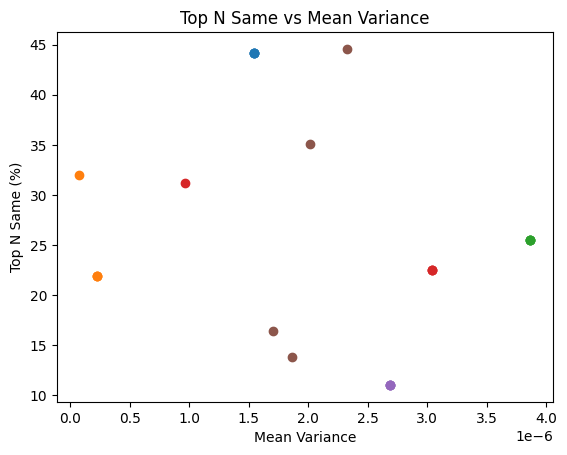

In [30]:
headers = ["MLP Shape", "Number of Neurons", "Number of Hidden Layers"] + [f"{percent}%" for percent in shrink_percentages]
rankings_variances_df = pd.DataFrame(columns=headers)
rankings_variances_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_variances_dict]
rankings_variances_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_variances_dict]
rankings_variances_df["Number of Hidden Layers"] = [len(x) for x in rankings_variances_df["MLP Shape"]]
rankings_variances_df[headers[3:]] = mean_variances
rankings_variances_df.sort_values("Number of Neurons", inplace=True)

for mlp in rankings_variances_df["MLP Shape"]:
    
    plt.scatter(rankings_variances_df[rankings_variances_df["MLP Shape"] == mlp].iloc[:, 3:].to_numpy()[0], top_n_same_df[top_n_same_df["MLP Shape"] == mlp].iloc[:, 3:].to_numpy()[0])


plt.xlabel("Mean Variance")
plt.ylabel("Top N Same (%)")
plt.title("Top N Same vs Mean Variance")

plt.show()

In [31]:
rankings_diff_df = pd.DataFrame(columns=headers)
rankings_diff_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["Number of Hidden Layers"] = [len(x) for x in rankings_diff_df["MLP Shape"]]
rankings_diff_df[headers[3:]] = rankings_diff
rankings_diff_df.sort_values("Number of Neurons", inplace=True)

rankings_diff_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})


,20%,40%,60%,80%
mean,33.268449,33.986014,33.631599,33.460049
max,40.048008,40.048008,40.048008,40.048008
min,27.870008,27.984373,27.984373,27.984373


In [32]:
top_in_top_n_df = pd.DataFrame(columns=headers)
top_in_top_n_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["Number of Hidden Layers"] = [len(x) for x in top_in_top_n_df["MLP Shape"]]
top_in_top_n_df[headers[3:]] = top_in_top_n
top_in_top_n_df.sort_values("Number of Neurons", inplace=True)

top_in_top_n_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,40.497076,31.871345,30.701754,29.239766
max,57.894737,56.140351,56.140351,56.140351
min,0.000000,0.000000,0.000000,0.000000


In [33]:
pearson_coeffs_df = pd.DataFrame(columns=headers)
pearson_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["Number of Hidden Layers"] = [len(x) for x in pearson_coeffs_df["MLP Shape"]]
pearson_coeffs_df[headers[3:]] = pearson_coeffs
pearson_coeffs_df.sort_values("Number of Neurons", inplace=True)

pearson_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.694536,0.715675,0.719012,0.724184
max,0.840721,0.840721,0.840721,0.840721
min,0.384048,0.384048,0.384048,0.384048


In [34]:
kendalltau_coeffs_df = pd.DataFrame(columns=headers)
kendalltau_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["Number of Hidden Layers"] = [len(x) for x in kendalltau_coeffs_df["MLP Shape"]]
kendalltau_coeffs_df[headers[3:]] = kendalltau_coeffs
kendalltau_coeffs_df.sort_values("Number of Neurons", inplace=True)

kendalltau_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.786187,0.800878,0.803395,0.807164
max,0.889354,0.889354,0.889354,0.889354
min,0.575410,0.575410,0.575410,0.575410


In [35]:
average_top_same_df = pd.DataFrame(columns=headers)
average_top_same_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in non_averaged_rankings_percents]
average_top_same_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in non_averaged_rankings_percents]
average_top_same_df["Number of Hidden Layers"] = [len(x) for x in average_top_same_df["MLP Shape"]]
average_top_same_df[headers[3:]] = [np.mean(non_averaged_rankings_percents[x], axis=0) for x in non_averaged_rankings_percents]
average_top_same_df.sort_values("Number of Neurons", inplace=True)

average_top_same_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,18.567251,16.691033,18.171296,16.544834
max,56.578947,36.257310,36.257310,36.257310
min,0.000000,0.000000,0.000000,0.000000


In [36]:
non_averaged_kendall = np.zeros((len(non_averaged_kendalltau_coeffs_dict), len(shrink_percentages)))

for m, mlp in enumerate(non_averaged_kendalltau_coeffs_dict):

    non_averaged_kendall[m] = np.mean(non_averaged_kendalltau_coeffs_dict[mlp].squeeze(), axis=0)

non_averaged_kendall_df = pd.DataFrame(columns=headers)
non_averaged_kendall_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in non_averaged_kendalltau_coeffs_dict]
non_averaged_kendall_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in non_averaged_kendalltau_coeffs_dict]
non_averaged_kendall_df["Number of Hidden Layers"] = [len(x) for x in non_averaged_kendall_df["MLP Shape"]]
non_averaged_kendall_df[headers[3:]] = non_averaged_kendall
non_averaged_kendall_df.sort_values("Number of Neurons", inplace=True)

In [37]:
non_averaged_kendall_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.993412,0.990454,0.989719,0.988832
max,0.996370,0.992095,0.991769,0.991769
min,0.991055,0.987399,0.987399,0.982361


In [38]:
non_averaged_pearson = np.zeros((len(non_averaged_pearson_coeffs_dict), len(shrink_percentages)))

for m, mlp in enumerate(non_averaged_pearson_coeffs_dict):
    non_averaged_pearson[m] = np.mean(non_averaged_pearson_coeffs_dict[mlp].squeeze(), axis=0)

non_averaged_pearson_df = pd.DataFrame(columns=headers)
non_averaged_pearson_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in non_averaged_pearson_coeffs_dict]
non_averaged_pearson_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in non_averaged_pearson_coeffs_dict]
non_averaged_pearson_df["Number of Hidden Layers"] = [len(x) for x in non_averaged_pearson_df["MLP Shape"]]
non_averaged_pearson_df[headers[3:]] = non_averaged_pearson
non_averaged_pearson_df.sort_values("Number of Neurons", inplace=True)

In [39]:
non_averaged_pearson_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.765237,0.690185,0.686890,0.685655
max,0.970433,0.964940,0.945168,0.937761
min,0.558833,0.417660,0.417660,0.417660
